In [2]:
import os
import math
import numpy as np
import pybat.core as pb

# MRS Advances: Analysis

This notebook is a short and schematic summary of the analysis performed for my MRS Advances paper, which discusses and compares the formation of oxygen dimers in Li$_{0.5}$MnO$_3$ and Li$_{0.5}$IrO$_3$. Here's a little TODO list I added for myself:

* [ ] Add the setup of the calculations in more detail. You could add input files, or simply refer the readers to the workflow scripts used.  

## Oxygen Oxidation

To start our analysis, we take a look at the magnetic moments of the various elements in both structures. We want to compare the magnetic moments on the Mn, Ir and O atoms for the discharged and 75% charged structure. As we have relaxed all bulk structures with HSE06, we can use these results to discuss the change in oxidation state, by analyzing the change in magnetic moments. Here's how we can extract the magnetic moments from the Outcar using pymatgen's vasp I/O:



In [3]:
from pymatgen.io.vasp.outputs import Outcar

pybat_data_dir = "/Users/mbercx/Dropbox/Phd/projects/batteries/data"

li2mno3_out = Outcar(os.path.join(pybat_data_dir, "Li2MnO3/discharged/o3-abc_afm/bulk/hse/scf_pv/OUTCAR"))
li2mno3_out.magnetization

({'d': 0.0, 'p': -0.0, 's': -0.0, 'tot': -0.0},
 {'d': 0.0, 'p': -0.0, 's': -0.0, 'tot': -0.0},
 {'d': 0.0, 'p': 0.0, 's': 0.0, 'tot': 0.0},
 {'d': 0.0, 'p': -0.0, 's': -0.0, 'tot': -0.0},
 {'d': 2.973, 'p': 0.029, 's': 0.013, 'tot': 3.014},
 {'d': -2.973, 'p': -0.029, 's': -0.013, 'tot': -3.014},
 {'d': 0.0, 'p': 0.001, 's': 0.0, 'tot': 0.001},
 {'d': 0.0, 'p': -0.001, 's': -0.0, 'tot': -0.001},
 {'d': 0.0, 'p': -0.002, 's': -0.0, 'tot': -0.002},
 {'d': 0.0, 'p': -0.001, 's': -0.0, 'tot': -0.001},
 {'d': 0.0, 'p': 0.002, 's': 0.0, 'tot': 0.002},
 {'d': 0.0, 'p': 0.001, 's': 0.0, 'tot': 0.001})

We can see that the output of the magnetization is given in terms of the various orbitals and the total for each atom in the structure. Let's extract the total for each element and average the absolute value of the magnetic moment:

In [4]:
total_magnetization = [atom['tot'] for atom in li2mno3_out.magnetization]
li2mno3_magmom = dict()
li2mno3_magmom["Mn"] = (sum([abs(mag) for mag in total_magnetization[4:6]]))/2
li2mno3_magmom["O"] = (sum([abs(mag) for mag in total_magnetization[6:]]))/6
print("Li2MnO3: magnetization on Mn = " + str(li2mno3_magmom["Mn"]))
print("Li2MnO3: magnetization on O = " + str(round(li2mno3_magmom["O"], 3)))

Li2MnO3: magnetization on Mn = 3.014
Li2MnO3: magnetization on O = 0.001


This could be done a lot better, really. I could write a little script to just get this automatically. But it'll do for now, considering we have a paper to finish. Let's continue with the other structures:

In [5]:
li05mno3_out = Outcar(os.path.join(pybat_data_dir, "Li2MnO3/0.5/O1-1a/bulk/hse_relax/OUTCAR"))
total_abs_magnetization = [abs(atom['tot']) for atom in li05mno3_out.magnetization]
li05mno3_magmom = dict()
li05mno3_magmom["Mn"] = (sum(total_abs_magnetization[1:3]))/2
li05mno3_magmom["O"] = (sum(total_abs_magnetization[3:]))/6
print("Li0.5MnO3: magnetization on Mn = " + str(li05mno3_magmom["Mn"]))
print("Li0.5MnO3: magnetization on O = " + str(round(li05mno3_magmom["O"], 3)))

Li0.5MnO3: magnetization on Mn = 2.963
Li0.5MnO3: magnetization on O = 0.45


In [6]:
li2iro3_out = Outcar(os.path.join(pybat_data_dir, "Li2IrO3/discharged/o3-abc/bulk/hse_relax/OUTCAR"))
total_abs_magnetization = [abs(atom['tot']) for atom in li2iro3_out.magnetization]
li2iro3_magmom = dict()
li2iro3_magmom["Ir"] = (sum(total_abs_magnetization[4:6]))/2
li2iro3_magmom["O"] = (sum(total_abs_magnetization[6:]))/6
print("Li2IrO3: magnetization on Ir = " + str(li2iro3_magmom["Ir"]))
print("Li2IrO3: magnetization on O = " + str(round(li2iro3_magmom["O"], 3)))

Li2IrO3: magnetization on Ir = 0.7315
Li2IrO3: magnetization on O = 0.076


In [7]:
li05iro3_out = Outcar(os.path.join(pybat_data_dir, "Li2IrO3/0.5/o1-1a/bulk/hse_relax/OUTCAR"))
total_abs_magnetization = [abs(atom['tot']) for atom in li05iro3_out.magnetization]
li05iro3_magmom = dict()
li05iro3_magmom["Ir"] = (sum(total_abs_magnetization[1:3]))/2
li05iro3_magmom["O"] = (sum(total_abs_magnetization[3:]))/6
print("Li0.5MnO3: magnetization on Ir = " + str(li05iro3_magmom["Ir"]))
print("Li0.5MnO3: magnetization on O = " + str(round(li05iro3_magmom["O"], 3)))

Li0.5MnO3: magnetization on Ir = 1.165
Li0.5MnO3: magnetization on O = 0.371


This was probably not the most efficient way of doing this. This task could have been more easily performed by just copying the values into MATLAB and making the figure. But it could serve as a tutorial in the future. Also, if I now decide to change de data file, it's easy peasy.

## Oxygen Lattice framework distortion

Next we'll take a look at the distances between the oxygen atoms. One way to do this would be to open the structure files in VESTA, and then click a lot. But clicking is for people that don't know Python. We've already written a script that uses the voronoi decomposition of the structure in order to find the neighbors, and then reconstruct the potential oxygen dimers around a specific site. So let's do that. Starting by loading the fully discharged and 75% charged structures of Li$_2$MnO$_3$:

In [8]:
from pybat.core import Cathode, LiRichCathode

li2mno3_cat = LiRichCathode.from_file(
    os.path.join(pybat_data_dir, "Li2MnO3/discharged/o3-abc_afm/bulk/dftu_relax/final_cathode.json") # DFTU data for now, while HSE relaxation finishes.
)
li05mno3_cat = LiRichCathode.from_file(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/o1-1a/bulk/hse_relax/final_cathode.json")
)
print(li2mno3_cat)
print()
print(li05mno3_cat)

Full Formula (Li4 Mn2 O6)
Reduced Formula: Li2MnO3
abc   :   4.979788   4.979788   5.073692
angles:  80.383533  80.383531 119.882393
Sites (12)
  #    #VESTA  SP            a          b          c    magmom
---  --------  ----  ---------  ---------  ---------  --------
  0         1  Li     0.5        0.5        0            0
  1         2  Li    -0         -0          0.5          0
  2         3  Li     0.661809   0.338191   0.5          0
  3         4  Li     0.338191   0.661809   0.5         -0
  4         5  Mn     0.167033   0.832967   0            3.041
  5         6  Mn     0.832967   0.167033  -0           -3.041
  6         7  O      0.781049   0.781049   0.228685    -0
  7         8  O      0.218951   0.218951   0.771315     0
  8         9  O      0.066414   0.42414    0.224551    -0.002
  9        10  O      0.57586    0.933586   0.775449    -0.002
 10        11  O      0.933586   0.57586    0.775449     0.002
 11        12  O      0.42414    0.066414   0.224551     0.00

These have been fully optimized and re-optimized in order to avoid [Pulay stresses.](http://cms.mpi.univie.ac.at/vasp/guide/node161.html) (Notice how you can add links to the markdown. Easy and useful.) Next, we use some Python magic to find all of the distances for both structures and put then in a nice and sorted `List`:

In [9]:
li2mno3_distances = [li2mno3_cat.distance_matrix[indices] for indices in li2mno3_cat.find_oxygen_dimers(4)]
li2mno3_distances.sort(); li2mno3_distances 

[2.574242106443846,
 2.574242123892187,
 2.6030370413569446,
 2.7745158036884083,
 2.7745158036884083,
 2.7745158226175515,
 2.774515822617552,
 2.7795183447383067,
 2.7795183447383067,
 2.790746672654144,
 2.8078407335807345,
 2.807840789092908]

In [10]:
li05mno3_distances = [li05mno3_cat.distance_matrix[indices] for indices in li05mno3_cat.find_oxygen_dimers(4)]
li05mno3_distances.sort(); li05mno3_distances 

[2.3124041152433468,
 2.3126853042936895,
 2.3127356919283955,
 2.6168898525079354,
 2.616974501342241,
 2.6169763523391047,
 2.7338833507734783,
 2.7338833507734788,
 2.7338846758823503,
 2.733884675882352,
 2.7339333369247534,
 2.7339333369247543]

We can immediately see that the discharged structure has a long and short distance (within a certain margin of error). For the charged structure, the short distance has shortened by about 0.1 angstrom (Oh, yeah, the distances are expressed in angstrom, FYI). Three of the long distances have shortened as well, and I have a suspicion that it are the ones that are slightly longer in the original structure. 

Below you can find an incorrect analysis I've left in for reminding myself later.

```
Hmm, some of the distances increase! Either the `find_oxygen_dimers` method somehow does not find two lists that correspond for the two structures, or the distortion is more interesting than just a reduction in the distances for the oxygen pairs. That could be possible, and maybe dependent on the lithium configuration. Let's look into this later. For now we'll just mention that the shorter distances get shorter, whereas most of the longer ones stay the same, which leads to a deformation. The shorter distances getting shorter corresponds to the formation of dimers in the view of Artem's science article. Note: Maybe the oxygen pairs don't correspond, because of course the O3->O1 transformation changes the octaheders quite a bit. Might be worth looking into and discussing in the paper.
```

Confirmed pretty much that the oxygen dimers do not correspond. I.e. substracting the two oxygen dimer distances lists does not make sense. The distances found in the matrix above were compared with those found in VESTA (Yeah, by clicking), and the following are the three different oxygen pair variants:

- The shortest distance corresponds to oxygens that have two Mn neighbors.
- The longest distance in the discharged structure turns into a medium distance (~2.80 -> 2.69)
- The 2.77 A distance, which remains largely unchanged, corresponds to the 'in oxygen plane' distances. There are six, three in the top triangle of the octahedron, three in the bottom.

Let's do a similar analysis for Li2IrO3

In [11]:
li2iro3_cat = LiRichCathode.from_file(
    os.path.join(pybat_data_dir, "Li2IrO3/discharged/o3-abc/bulk/hse_relax/final_cathode.json")
)
li05iro3_cat = LiRichCathode.from_file(
    os.path.join(pybat_data_dir, "Li2IrO3/0.5/o1-1a/bulk/hse_relax/final_cathode.json")
)

li2iro3_distances = [li2iro3_cat.distance_matrix[indices] for indices in li2iro3_cat.find_oxygen_dimers(4)]
li2iro3_distances.sort(); li2iro3_distances
 

[2.707754894055229,
 2.707754894055229,
 2.8318495525791834,
 2.8450479619952835,
 2.8618431276485006,
 2.861843127648501,
 2.8618431276485015,
 2.8618431276485015,
 2.8818142687693142,
 2.881814268769315,
 2.9170118029520604,
 2.9170118029520604]

In [12]:
li05iro3_distances = [li05iro3_cat.distance_matrix[indices]
                      for indices in li05iro3_cat.find_oxygen_dimers(4)]
li05iro3_distances.sort(); li05iro3_distances
sum(li05iro3_distances[3:6])/3

2.7404189574516873

Interesting, there seems to be a little case of symmetry breaking in the Li2IrO3 structure. One of the short distances is actually significantly higher than the others, whereas one of the in-oxygen-layer distances has decreased slightly. However, 

## Li configuration analysis

In order to study partially charged structures, such as Li$_{0.5}$MnO$_3$ and Li$_{0.5}$IrO$_3$, a choice must be made for the Lithium configuration. Hence, it is important to investigate the optimal lithium configuration, by comparing the formation energies of the various lithium configurations. We will not add this discussion to the paper extensively though, as this has been investigated before. We'll just mention that our results correspond to the ones in the literature. Which is accurate. I might add the actual analysis later to show how we checked this. For now, you'll have to [trust me](https://media1.tenor.com/images/7d64c9003647a2e846eede7ffef1a63a/tenor.gif?itemid=5698466).

## Oxygen dimer analysis

Alright, we've convinced ourselves that the oxygen oxidated in both structures as we remove the lithium. We've also noted that the oxygen framework is distored slightly by this removal. However, what we are really interested in is to see whether this all leads to the formation of proper oxygen dimers, i.e. oxygen pairs which are bonded convalently, sharing electrons and in such a way replenishing their p-orbitals to remove their magnetic moments. To investigate the formation of dimers, we need to check which pairs of oxygen that are connected in the octahedral environment of a cation site can form a dimer. The basic step of seeing whether such a dimer can be formed, is just pushing the oxygen pair closer together, and optimizing the structure. If the new structure is optimized and forms a stable dimer, we compare the total energy with that of the original pre-dimer structure. If the energy lower, there is a thermodynamic argument to be made that the structure wants to form such dimers. The next question is whether this is kinetically possible, but we'll answer that later.

### Symmetry analysis
Of course, we need to study the dimer formation in a sufficiently large supercell of the original structure, or we'll be investigating more of a phase transformation than the formation of a defect, which is how we interpret the local formation of a dimer. We don't want to just pick a few oxygen pairs in the structure, however, and check whether they form a dimer. Instead, we want to be complete, i.e. study all non-equivalent oxygen pairs with the potential to form a dimer. What we've done for the structures is start with an analysis of the symmetry of the structure in order to find a list of the inequivalent dimers. The dimers themselves are found by analysing the neighbours around each site, using the `pymatgen.chemenv` module. Let's start by loading our in-house developed `pybat` package and loading the 2x2x2 supercell O1-Li$_{0.5}$MnO$_3$ structure with the 1a cation configuration for the Li atoms:

In [13]:
import pybat.core as pb

cat = pb.LiRichCathode.from_file(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/O1-1a/2x2x2/dftu_relax/final_cathode.json")
)

Note that this strucure has been constructed from the optimized primitive unit cell, and optimized in turn. Let's have a look at our final cathode structure:

In [14]:
print(cat)

Full Formula (Li8 Mn16 O48)
Reduced Formula: LiMn2O6
abc   :   9.996316   9.996316   8.225567
angles:  90.000000  90.000000 120.000000
Sites (96)
  #  #VESTA    SP           a         b          c    magmom
---  --------  ----  --------  --------  ---------  --------
  0  1         Li    0         0         -0            0.003
  1  2         Li    0         0          0.5          0.003
  2  3         Li    0         0.5       -0            0.003
  3  4         Li    0         0.5        0.5          0.003
  4  5         Li    0.5       0         -0            0.003
  5  6         Li    0.5       0          0.5          0.003
  6  7         Li    0.5       0.5       -0            0.003
  7  8         Li    0.5       0.5        0.5          0.003
  8  -         Vac   1         0          0.25         0
  9  -         Vac   0         0          0.75         0
 10  -         Vac   0         0.5        0.25         0
 11  -         Vac   0         0.5        0.75         0
 12  -         V

Note that the structure also keeps track of the vacancies. These are kept in the structure in order for the Voronoi decomposition of the `chemenv` package to keep functioning properly, as well as making it easier to define a migration of the transition metals. The #VESTA column in the printed string is just to figure out the corresponding atom when opening the corresponding POSCAR or .cif file in VESTA. Let's first take a look at how many potential dimers there are in the 2x2x2 unit cell of the structure:

In [15]:
len(cat.find_oxygen_dimers())

438

This takes a little longer, because setting up the Voronoi decomposition for the structure using the `pymatgen.analysis.chemenv` package takes some time. It would take quite some time to calculate the formation energy for all of these potential dimers. Fortunately, we've also implemented a method for finding the inequivalent dimers in a structure:

In [16]:
cat.find_noneq_dimers()

[(64, 54), (64, 77), (54, 76), (81, 48), (81, 89), (88, 64)]

You can see that of all the dimers in the structure, there are only 6 inequivalent ones. This makes the analysis of the stability of the oxygen framework somewhat easier. I've built upon this method in combination with the `fireworks` package in order to set up a workflow that immediately calculates the formation energy for all the non-equivalent dimers. I won't be executing this here, as it sends these workflows to the pybat server on mLab (Soon to be Mongo DB Atlas.). 

The OUTCAR's of the scf calculation on the optimized structures are put in `data/dimer_thermo/`. I've only added the ones of the dimers for which the energy actually decreases. The full analysis will have to be done later.

Just as a clarification: The above dimers' indices for do not correspond to the ones that were chosen be the workflow script. That script actually finds the dimers that are the closest to the center of the unit cell, for easy visualisation purposes. However, the dimer combinations that I actually have analyzed all have an equivalent dimer in the list above. To check this, here you can find the lists of equivalent dimers for the list on inequivalent dimers (if that makes sense to you).

In [17]:
dimer_lists = cat.list_noneq_dimers()

That probably took a while. It's most likely not the most efficient implementation, but it's fine for our purposes. To convince you that the dimers I analyze below correspond to one of the dimers in the list above, you can use the following little piece of code to find the dimer it corresponds to.

In [18]:
dimer_search = (80, 49)

for list in dimer_lists:
    if dimer_search in list:
        equivalent_dimer = list[0]
        print("Found requested dimer in list of " + str(equivalent_dimer))

# Let's check it
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
symmops = SpacegroupAnalyzer(cat).get_space_group_operations()
symmops.are_symmetrically_equivalent(
    [cat.sites[index] for index in dimer_search],
    [cat.sites[index] for index in equivalent_dimer]
)


Found requested dimer in list of (81, 48)


True

This should show one of the dimers in the above list, and say True. If it doesn't, please contact me, because then I really have to start writing some units tests.

### Thermodynamics

So let's take a look at the energies of the dimer structures and compare them with that of the original charged structure. First, we'll load the output data from the OUTCAR files of the SCF calculations, performed after the geometric optimizations:

In [20]:
out_original = Outcar(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/o1-1a/2x2x2/dftu_relax/dftu_scf/OUTCAR")
)
out_48_92 = Outcar(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/o1-1a/2x2x2/dftu_dimers/dimer_48_92/final/dftu_scf/OUTCAR")
)
out_80_49 = Outcar(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/o1-1a/2x2x2/dftu_dimers/dimer_80_49/final/dftu_scf/OUTCAR")
)

Parsing the Outcar files can take some time, especially for long geometric optimization runs. (Another reason why I should be working on a post-processing script... Parsing through this huge file for just extracting the total energy is absurd.) Note how I've used the final energy of an SCF calculation, performed on top of the geometry optimization. Especially for comparing these large supercells, the energy between the geometry optimization and the consequent SCF calculation can differ quite a bit. Extracting the final energies from the outcar object is fairly easy. It simply has a final energy property:

In [21]:
out_original.final_energy

-442.49177984

So, let's use that to calculate the energy differences:

In [22]:
print("The energy difference for dimer 48-92 is: " 
      + str(round(out_48_92.final_energy - out_original.final_energy,3)) + " eV")
print("The energy difference for dimer 80-49 is: "
      + str(round(out_80_49.final_energy - out_original.final_energy, 3)) + " eV")

The energy difference for dimer 48-92 is: -0.083 eV
The energy difference for dimer 80-49 is: -0.553 eV


So, if everything worked out, this should say that both dimers have a lower energy than the original structure, i.e. a negative energy difference. That's pretty much all there is to analyzing the thermodynamics of the dimer formation. 

### Oxidation

However, let's also take a look at the oxidation states of the oxygen atoms in the final geometry. However, to actually check the corresponding indices, we need to use the Cathode object. So, let's load the `Cathode` of the 80-49 dimer structure:

In [23]:
cat_80_49 = Cathode.from_file(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/o1-1a/2x2x2/dftu_dimers/dimer_80_49/final/dftu_scf/final_cathode.json")
)
print(cat_80_49)

Full Formula (Li8 Mn16 O48)
Reduced Formula: LiMn2O6
abc   :   9.996316   9.996316   8.225567
angles:  90.000004  90.000000 119.999998
Sites (96)
  #  #VESTA    SP           a         b         c    magmom
---  --------  ----  --------  --------  --------  --------
  0  1         Li    0.004931  0.004915  0.000383     0.003
  1  2         Li    0.989013  0.989044  0.506886     0.003
  2  3         Li    1.7e-05   0.500071  9e-06        0.003
  3  4         Li    0.998331  0.501484  0.499964     0.003
  4  5         Li    0.499983  0.999929  0.999991     0.003
  5  6         Li    0.501669  0.998516  0.500036     0.003
  6  7         Li    0.495069  0.495085  0.999617     0.003
  7  8         Li    0.510987  0.510956  0.493114     0.003
  8  -         Vac   1         0         0.25         0
  9  -         Vac   0         0         0.75         0
 10  -         Vac   0         0.5       0.25         0
 11  -         Vac   0         0.5       0.75         0
 12  -         Vac   0.5      

In [24]:
print("The total magnetic moment of oxygen(80) is: " + str(cat_80_49.site_properties["magmom"][80]))
print("The total magnetic moment of oxygen(49) is: " + str(cat_80_49.site_properties["magmom"][49]))

The total magnetic moment of oxygen(80) is: -0.142
The total magnetic moment of oxygen(49) is: -0.142


We can see that the magnetic moment on both oxygens has been reduced significantly to its magnetic moment before the dimer formation. The other oxygens in the structure still have a much larger magnetic moment. This indicates that the oxygens which have a dimer have actually reduced their oxidation state close to -2 by forming a dimer. In order to find the average magnetic moments of the other oxygen atoms, we use a little python magic:

In [25]:
magmoms = [cat_80_49.site_properties["magmom"][index] for index in range(len(cat_80_49))
           if cat.sites[index].species_string is "O" and index not in [80, 49]]
print("The average of the magnetic moment of the non-dimer oxygen atoms is: " +
      str(round(np.mean(magmoms), 3)))

The average of the magnetic moment of the non-dimer oxygen atoms is: -0.438


Easy peasy! Let's do the same analysis for the other dimer:

In [26]:
cat_48_92 = Cathode.from_file(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/O1-1a/2x2x2/dftu_dimers/dimer_48_92/final/dftu_scf/final_cathode.json")
)
print("The total magnetic moment of oxygen(48) is: " + str(cat_48_92.site_properties["magmom"][48]))
print("The total magnetic moment of oxygen(92) is: " + str(cat_48_92.site_properties["magmom"][92]))
magmoms = [cat_48_92.site_properties["magmom"][index] for index in range(len(cat_48_92))
           if cat.sites[index].species_string is "O" and index not in [48, 92]]
print("The average of the magnetic moment of the non-dimer oxygen atoms is: " +
      str(round(np.mean(magmoms), 3)))

The total magnetic moment of oxygen(48) is: -0.127
The total magnetic moment of oxygen(92) is: -0.127
The average of the magnetic moment of the non-dimer oxygen atoms is: -0.439


We can see a similar result as for the first dimer: The oxygen atoms that participate in the dimer formation have a severely reduced magnetic momentum, whereas the other oxygens have a similar average magnetic momentum as for the first dimer.

### NEB Analysis

Finally, in order to study the kinematics of the dimer transitions, we have performed a Nudged Elastic Band calculation. We'll first use the built in method for making figures from `pymatgen`. This is a very slow method, though, so you'll have to be a little patient (if you're running the notebook).

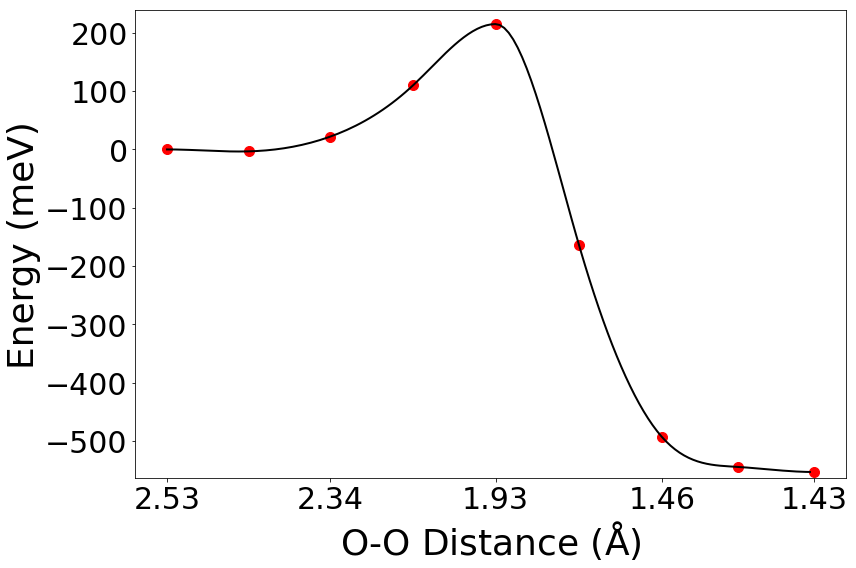

In [48]:
neb_80_49 = pb.DimerNEBAnalysis.from_file(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/o1-1a/2x2x2/dftu_dimers/dimer_80_49/neb_data.json")
)
neb_80_49.setup_spline({"saddle_point": "zero_slope"})
neb_80_49.get_plot(label_barrier=False).show()

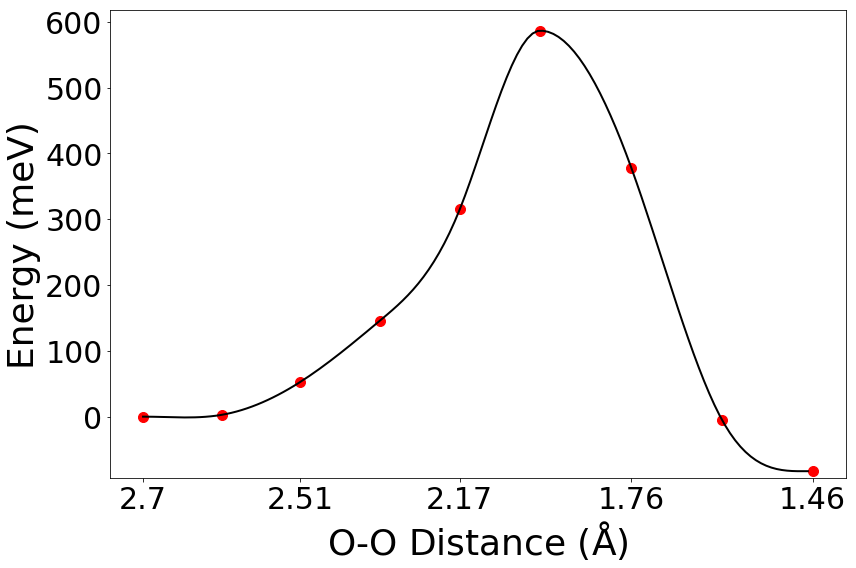

In [36]:
neb_48_92 = pb.DimerNEBAnalysis.from_file(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/O1-1a/2x2x2/dftu_dimers/dimer_48_92_vtst/neb_data.json")
)
neb_48_92.setup_spline({"saddle_point": "zero_slope"})
neb_48_92.get_plot(label_barrier=False).show()

These barriers look all right! And hence they are added to the paper. We ran into some issues with the VTST implementation of VASP for the first barrier, though:

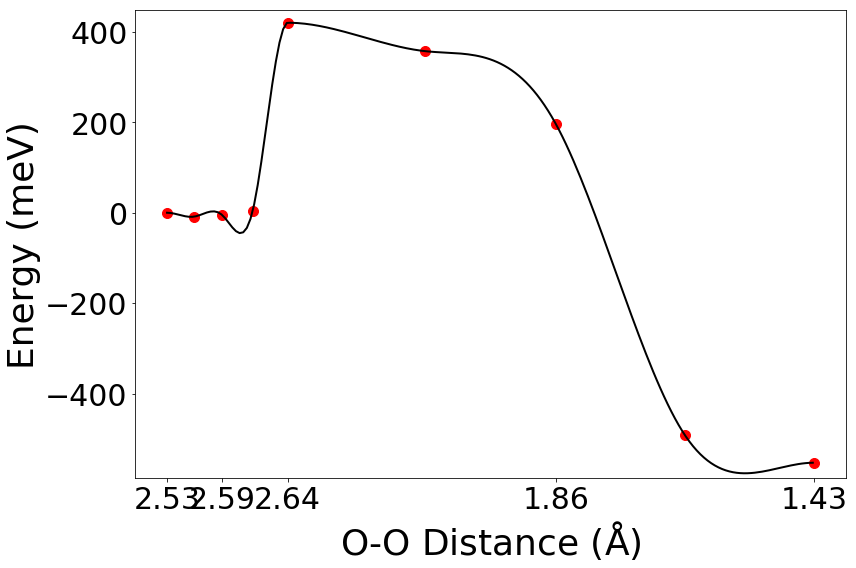

In [50]:
neb_80_49 = pb.DimerNEBAnalysis.from_file(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/o1-1a/2x2x2/dftu_dimers/dimer_80_49_vtst/neb_data.json")
)
neb_80_49.setup_spline({"saddle_point": "zero_slope"})
neb_80_49.get_plot(label_barrier=False).show()

The barrier is messed up somehow by the use of the VTST compilation of VASP, and hence the [LCLIMB](http://theory.cm.utexas.edu/vasp/neb.html#neb) tag, corresponding to the [climbing image modification](https://aip.scitation.org/doi/10.1063/1.1329672) of the nudged elastic band method. It's interesting that the initial energies are so close together. In light of that, let's take a look at the distances between the oxygen atoms in the dimer for these images:

In [51]:
print("O-O distances:")
for i in range(9):
    cat_00 = Cathode.from_file(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/o1-1a/2x2x2/dftu_dimers/dimer_80_49_vtst/0" + str(i) + "/final_cathode.json")
    )
    print("0" + str(i)+ ": " + str(cat_00.distance_matrix[(80, 49)]))

O-O distances:
00: 2.5328921365115074
01: 2.5604803344737976
02: 2.588962769764369
03: 2.618137830083277
04: 2.6388590611418796
05: 2.33309495828449
06: 1.8608167841530137
07: 1.4566918015006582
08: 1.4304228653863555


That explains the weird curve for the final nudged elastic band calculation! For some reason, the images have all clustered around the starting point. Some have even been pulled apart a bit, which results in the higher barrier. It's difficult to say what happened here, and the high value of the barrier is probably not trustworthy. 

Let's make a combination of the two by adding the 'reasonable' points

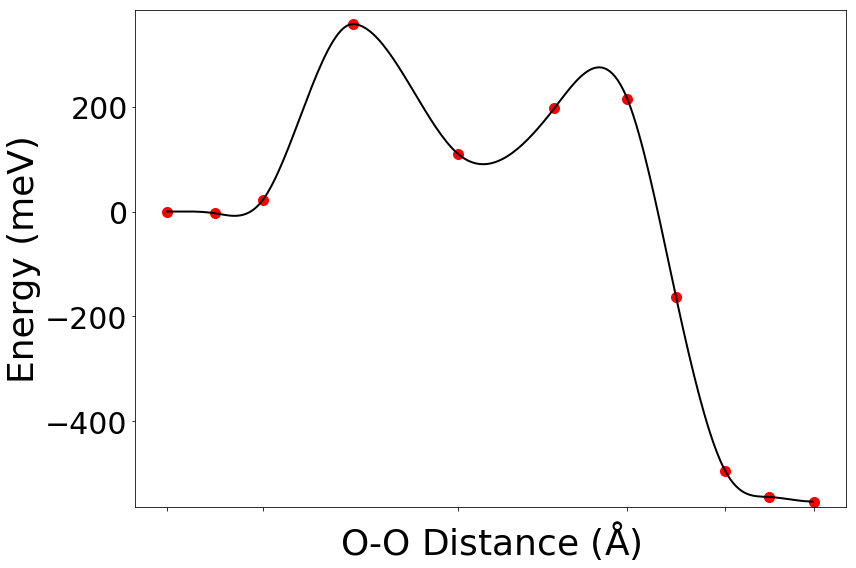

In [52]:
neb_80_49 = pb.DimerNEBAnalysis.from_dir(
    os.path.join(pybat_data_dir, "Li2MnO3/0.5/o1-1a/2x2x2/dftu_dimers/dimer_80_49_combination")
)
neb_80_49.setup_spline({"saddle_point": "zero_slope"})
neb_80_49.get_plot(label_barrier=False).show()

Maybe I messed up, let's look into this tomorrow.

## Various
### Figure help

This is just a place where I can do some tests to see which dimers correspond to which for the figures.

In [78]:
dimer_search_1 = (74, 92)
dimer_search_2 = (64, 56)

for list in dimer_lists:
    if dimer_search_1 in list:
        equivalent_dimer = list[0]
        print("Found requested dimer 1 in list of " + str(equivalent_dimer))
    if dimer_search_2 in list:
        equivalent_dimer = list[0]
        print("Found requested dimer 2 in list of " + str(equivalent_dimer))

# Let's check it
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
symmops = SpacegroupAnalyzer(cat).get_space_group_operations()
symmops.are_symmetrically_equivalent(
    [cat.sites[index] for index in dimer_search_1],
    [cat.sites[index] for index in dimer_search_2]
)

Found requested dimer 1 in list of (64, 54)
Found requested dimer 2 in list of (64, 54)


True

In [109]:
-447.47530514+446.97599473

-0.4993104099999641